# Nuestras Caras

Este código implementa una técnica de reconocimiento facial conocida como "Eigenfaces". 

La idea básica detrás de Eigenfaces es representar las caras de un conjunto de datos de entrenamiento en un espacio de características de dimensionalidad reducida utilizando el análisis de componentes principales (PCA). 

Luego, las nuevas caras se proyectan en este espacio de características y se comparan con las caras de entrenamiento para reconocerlas.

DEPENDENCIAS NECESARIAS:

Previo a ejecutar la notebook deben ser instaladas las siguientes dependencias:
* pip install opencv-python
* pip install pandas
* pip install matplotlib
* pip install scikit-learn

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from photo_30x30 import cortar_imagenes     # Función para recortar imagenes y pasar a grises
from pixels import intensidad_pixels    # Función para obtener la intensidad de los pixeles
import perceptrones as per        # Script con backpropagation

In [2]:
#********************************************************************************************************************
#                    CORTE DE LAS FOTOS Y CAMBIO DE ESCALA DE GRISES MEDIANTE PHOTO_30X30.PY
#********************************************************************************************************************
# Definimos donde se encuentran las fotos crudas y donde iran las grises 30x30
#current_directory = os.getcwd()
folder_name_raw = "input"
folder_name_output = "output"

# current_directory
# os.chdir(os.path.join(current_directory, "NuestrasCaras"))


# Cortar las fotos y cambiar a escala de grises
# cortar_imagenes(folder_name_raw, folder_name_output)


In [3]:
#********************************************************************************************************************
#                    OBTENCION DE LOS VALORES DE LOS PIXELES DE LAS FOTOS MEDIANTE PIXELS.PY
#********************************************************************************************************************
# Guardo la info de las fotos en un dataframe
folder_path_output = os.path.join(os.getcwd(), folder_name_output)
data_fotos = intensidad_pixels(folder_path_output)

# Get the file names
file_names = data_fotos.iloc[:, 0]

# Tomo los nombres de cada persona
people_names = [name.split("-")[0] for name in file_names]

# Tomo las escalas de grises y divido por 255 para normalizar
greyscale_values = data_fotos.iloc[:, 1:].values/255.0

#********************************************************************************************************************
# Separamos los data sets en training y test
#********************************************************************************************************************
# Mediante el parametro "stratify" nos aseguramos que se tomen todos los nombres
X_train, X_test, nombres_y_train, nombres_y_test = train_test_split(greyscale_values, people_names, test_size=0.2, random_state=42, stratify=people_names)

# Transformo los nombres a números (0-1) usando label binarizer
y_train = LabelBinarizer().fit_transform(nombres_y_train)
y_test = LabelBinarizer().fit_transform(nombres_y_test)

#********************************************************************************************************************

In [4]:
# Dimensiones del array
people_names = np.array(people_names)
people_names.shape

greyscale_values = np.array(greyscale_values)
greyscale_values.shape


(226, 900)

Text(0.5, 1.0, 'Cara Promedio')

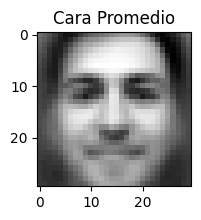

In [5]:
# obtiene y mustra la cara promedio
cara_promedio = np.mean(greyscale_values, axis=0)
cara_promedio.shape
plt.figure(figsize=(3, 2))
plt.imshow(cara_promedio.reshape(30,30),cmap="gray")
plt.title('Cara Promedio')

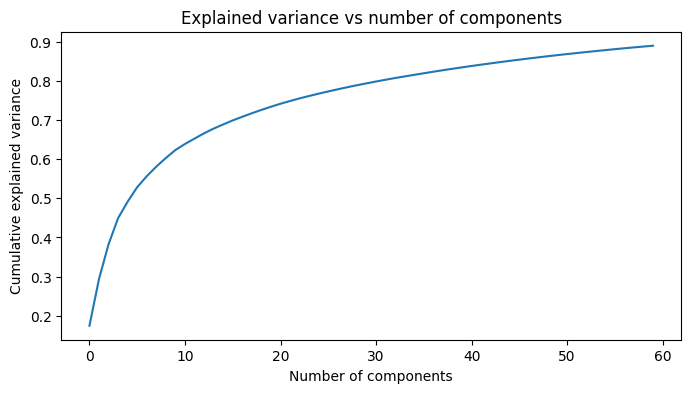

In [6]:
#********************************************************************************************************************
#                    PCA
#********************************************************************************************************************
# Se aplica PCA a las imagenes
# IMPORTANTE! al aumentar el nro de componentes tambien aumenta la precision en la comparacion de imagenes para la clasificacion al final de la notebook!
# Tiene sentido porque aumento el porcentaje de variabilidad explicada por las componentes, acercandome mas a la realidad
n_pca = 60
pca = PCA(n_components=n_pca).fit(X_train)
X_train_pca = pca.fit_transform(X_train)

eigenfaces = pca.components_
varianza_explicada = pca.explained_variance_ratio_

# plot explained variance (grafico continuo)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(varianza_explicada))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()


Se observa que con aproximadamente 40 CP explicamos el 80% de la varianza. Y con 60 CP, nos acercamos al 90%.

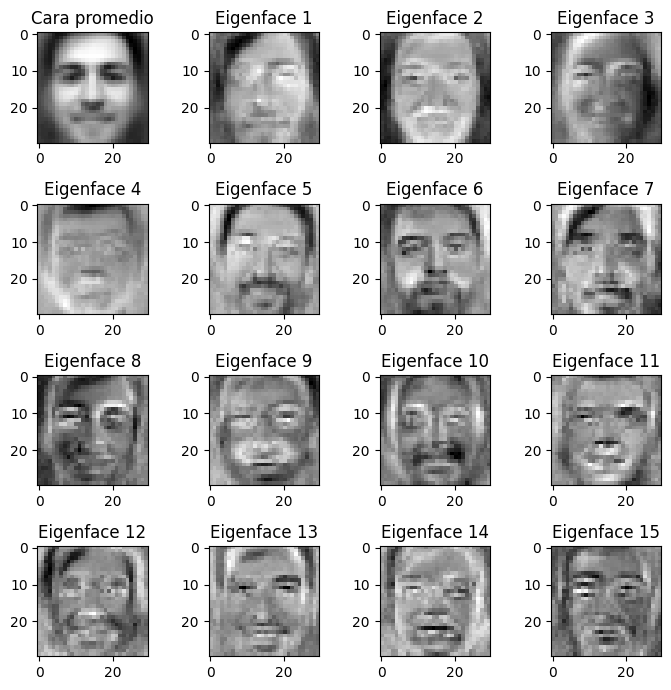

In [7]:
#********************************************************************************************************************
#                    GRAFICO DE LAS PRIMERAS 15 EIGENFACES
#********************************************************************************************************************

fig, ax = plt.subplots(4, 4, figsize=(7, 7))

ax[0, 0].imshow(cara_promedio.reshape(30,30), cmap="gray")
ax[0, 0].set_title("Cara promedio")

for i in range(0,15): # primeras 15 pca
    ax[(i+1) // 4, (i+1) % 4].imshow(eigenfaces[i].reshape(30,30), cmap="gray")
    ax[(i+1) // 4, (i+1) % 4].set_title(f"Eigenface {i+1}")

#plot dimensions
plt.tight_layout()
plt.show()

### Entrenamiento de la red neuronal con backpropagation
Comienza inicializando las matrices de pesos de manera aleatoria y realizando la propagación hacia adelante para obtener las salidas de la red. Luego, se calcula el error promedio y se inicia un bucle de entrenamiento que continúa hasta que se cumpla un criterio de convergencia o se alcance el límite de épocas. En cada iteración, se realiza la propagación hacia adelante y hacia atrás para ajustar los pesos mediante la corrección de errores. El proceso se repite hasta que se alcance la convergencia o el límite de épocas, mostrando el número de época y el valor del error en cada iteración.

In [8]:
#********************************************************************************************************************
# AHORA TENEMOS QUE USAR EL BACKPROPAGATION 
#********************************************************************************************************************


In [9]:
'''DEJO ESTE BLOQUE COMO COMENTARIO YA QUE DEMORA MUCHO EN CORRER

# Evaluamos la mejor combinacion de neuronas en las capas ocultas 1 y 2 (DEMORA MUCHO!)

# Creo una lista vacia para ir guardando los resultados
resultados = []

# Creo tres loops: 
# uno para la cantidad de neuronas en la capa 1, 
# otro para la cantidad de neuronas en la capa 2,
# y otro para la cantidad de fotos del test set

import time

for i in range(1,36):
    for j in range(1,36):
        start_time = time.time()
        red_neuronal = per.backpropagation_2_capas(X_train_pca, y_train, i, j, 2000, 1.0e-6, 0.3)
        pesos = red_neuronal[:6]
        aciertos = 0
        # tiempo de ejecucion
        tiempo = time.time() - start_time
        # epoch y error
        epoch = red_neuronal[-1]
        error = red_neuronal[-2]
        # Recorro las fotos del test set
        for k in range(0, len(y_test)):
            foto_prueba = X_test[k]
            foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
            prediccion = per.predecir_clase_2_capas(pesos, foto_prueba_pca)
            # Si la prediccion es correcta, suma 1 en aciertos
            if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
                aciertos += 1
        # El porcentaje acertado
        aciertos_pct = round(aciertos/len(y_test)*100,2)
        # Imprime combinacion de neuronas y aciertos
        print(f"*** Neuronas en primera capa: {i} *** Neuronas en segunda capa: {j} >>> Aciertos: {aciertos} ({aciertos_pct}%)")
        print('')
        # Guarda los resultados de esta combinacion en la lista
        resultados.append((i, j, tiempo, epoch, error, aciertos, aciertos_pct))



#********************************************************************************************************************
# Tarda tanto en correr que guardo los resultados en un archivo externo

# Guardo los resultados en un dataframe
resultados_df = pd.DataFrame(resultados, columns=["Neuronas_1", "Neuronas_2", "Tiempo", "Epoch", "Error", "Aciertos", "Porcentaje_Aciertos"])

# Guardo el dataframe en un archivo csv
resultados_df.to_csv("test_backpropagation.csv", index=False)

'''

'DEJO ESTE BLOQUE COMO COMENTARIO YA QUE DEMORA MUCHO EN CORRER\n\n# Evaluamos la mejor combinacion de neuronas en las capas ocultas 1 y 2 (DEMORA MUCHO!)\n\n# Creo una lista vacia para ir guardando los resultados\nresultados = []\n\n# Creo tres loops: \n# uno para la cantidad de neuronas en la capa 1, \n# otro para la cantidad de neuronas en la capa 2,\n# y otro para la cantidad de fotos del test set\n\nimport time\n\nfor i in range(1,36):\n    for j in range(1,36):\n        start_time = time.time()\n        red_neuronal = per.backpropagation_2_capas(X_train_pca, y_train, i, j, 2000, 1.0e-6, 0.3)\n        pesos = red_neuronal[:6]\n        aciertos = 0\n        # tiempo de ejecucion\n        tiempo = time.time() - start_time\n        # epoch y error\n        epoch = red_neuronal[-1]\n        error = red_neuronal[-2]\n        # Recorro las fotos del test set\n        for k in range(0, len(y_test)):\n            foto_prueba = X_test[k]\n            foto_prueba_pca = pca.transform(foto_pr

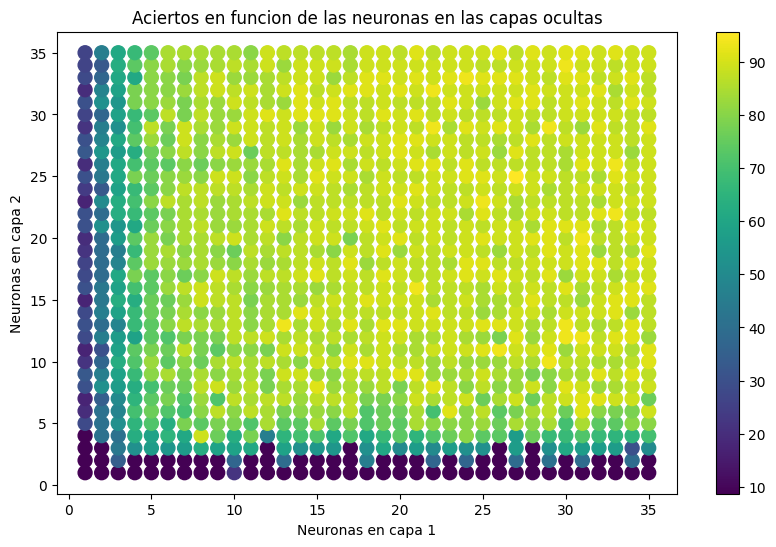

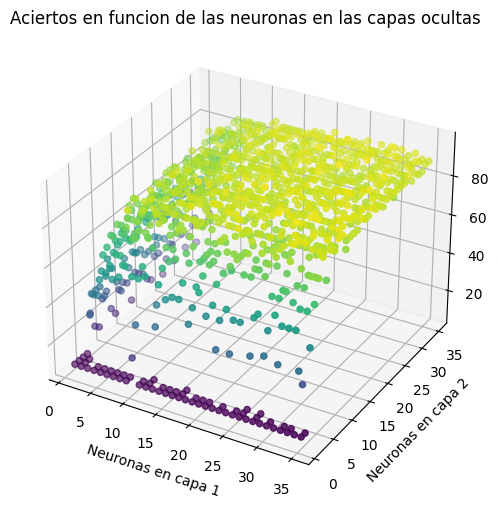

In [10]:
# Graficamos los resultados de la evaluacion de las neuronas en las capas ocultas
# Abrir csv
resultados = pd.read_csv("test_backpropagation.csv")

# Paso a numpy array
resultados = np.array(resultados)

# Tomos los porcentajes de aciertos
resultados_pct = resultados[:,6]

# Ploteo en un grafico 2D
plt.figure(figsize=(10, 6))
plt.scatter(resultados[:,0], resultados[:,1], c=resultados_pct, cmap='viridis', s=100)
plt.colorbar()
plt.xlabel('Neuronas en capa 1')
plt.ylabel('Neuronas en capa 2')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas')
plt.show()

# Ploteo en un grafico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(resultados[:,0], resultados[:,1], resultados_pct, c=resultados_pct, cmap='viridis')
ax.set_xlabel('Neuronas en capa 1')
ax.set_ylabel('Neuronas en capa 2')
ax.set_zlabel('Aciertos (%)')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas')
plt.show()

#********************************************************************************************************************





In [11]:
# Armo un ranking de las 20 mejores combinaciones segun el porcentaje de aciertos

# Me quedo solo con los valores de cada capa y el porcentaje de aciertos
ranking = resultados[:,[0,1,6]]
# Ordeno de mayor a menor porcentaje de aciertos
ranking = ranking[ranking[:,2].argsort()[::-1]]
# Me quedo con las mejores
ranking = ranking[:20]
print(ranking)

# Nos quedamos con la mejor combinacion de neuronas en las capas ocultas
# Podemos elegir si quedarnos con muchas neuronas en cada capa o reducirlo un poco



[[27.   25.   95.65]
 [22.   29.   93.48]
 [13.   13.   93.48]
 [33.   26.   93.48]
 [22.   32.   93.48]
 [24.   33.   93.48]
 [25.   23.   93.48]
 [29.   10.   93.48]
 [26.   11.   93.48]
 [29.   29.   93.48]
 [31.   20.   93.48]
 [21.   16.   93.48]
 [31.   12.   93.48]
 [33.   22.   93.48]
 [30.   13.   93.48]
 [30.   12.   93.48]
 [30.   34.   93.48]
 [23.    6.   91.3 ]
 [24.   25.   91.3 ]
 [29.   11.   91.3 ]]


In [12]:
#********************************************************************************************************************
# El mejor modelo
#********************************************************************************************************************
neuronas_1_best = 13
neuronas_2_best = 13

# Entrenamos el mejor modelo
red_neuronal_best = per.backpropagation_2_capas(X_train_pca, y_train, neuronas_1_best, neuronas_2_best, 2000, 1.0e-6, 0.3)
pesos_best = red_neuronal_best[:6]

#********************************************************************************************************************
# Evaluamos el mejor modelo

aciertos = 0
# Recorro las fotos del test set
for k in range(0, len(y_test)):
    status = "error"
    foto_prueba = X_test[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    prediccion = per.predecir_clase_2_capas(pesos_best, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
        aciertos += 1
        status = "OK"
    print(f"Prediccion: {nombres_y_test[prediccion[-1]]} - Real: {nombres_y_test[np.where(y_test[k]==1)[0][0]]} - {status}")


# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_test)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%)")

Error inicial: 0.3185226131383566
Epoch: 261, Error: 0.00018184556131650337
Prediccion: Paola - Real: Paola - OK
Prediccion: Noelia - Real: Noelia - OK
Prediccion: Federico R - Real: Federico R - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Victorio - Real: Victorio - OK
Prediccion: Franco A - Real: Franco A - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Juan - Real: Juan - OK
Prediccion: Noelia - Real: Noelia - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Joaquin - Real: Joaquin - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Lisandro - Real: Federico G - OK
Prediccion: Gustavo - Real: Gustavo - OK
Prediccion: Noelia - Real: Juan - OK
Prediccion: Victorio - Real: Victorio - OK
Prediccion: Paola - Real: Pa

In [18]:
# Prueba: Quitamos las primeras 3 CP

# Retiro las primeras 3 componentes
X_menos_3 = X_train_pca[:, 3:]
print(X_menos_3.shape)

# Red neuronal con las primeras 3 componentes quitadas
red_neuronal_best = per.backpropagation_2_capas(X_menos_3, y_train, neuronas_1_best, neuronas_2_best, 2000, 1.0e-6, 0.3)
pesos_best = red_neuronal_best[:6]

# Evaluamos el mejor modelo
aciertos = 0
# Recorro las fotos del test set
for k in range(0, len(y_test)):
    foto_prueba = X_test[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    foto_prueba_pca = foto_prueba_pca[:, 3:]
    prediccion = per.predecir_clase_2_capas(pesos_best, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
        aciertos += 1
    
# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_test)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%)")



(180, 57)
Error inicial: 0.2931180197654728
Epoch: 275, Error: 0.00018317112853710572
>>> Aciertos: 41 (89.13%)


In [14]:
# Prueba 2: Restamos la cara promedio
